In [1]:
import matplotlib.pyplot as plt
import scienceplots
import numpy as np
import json
import pandas as pd
import re
from functools import reduce
from collections import defaultdict

In [2]:
plt.style.use('science')

In [3]:
def build_intervals(event_list):
    """
    Convert a list of start/stop events into
    {thread_id: [(start_ns, end_ns), …]}.
    """
    intervals = defaultdict(list)
    pending = defaultdict(list)
    for ev in sorted(event_list, key=lambda x: x['timestamp_ns']):
        tid = ev['thread_id']
        if ev['start']:
            pending[tid].append(ev['timestamp_ns'])
        elif pending[tid]:
            start_ns = pending[tid].pop()
            intervals[tid].append((start_ns, ev['timestamp_ns']))
    return intervals

In [4]:
def is_active_at(ts_ns, thread_id, intervals_map):
    return any(start <= ts_ns <= end for start, end in intervals_map.get(thread_id, []))

In [5]:
def is_syscall_in_bench(syscall, bench_active_intervals):
    return is_active_at(syscall['start_timestamp_ns'], syscall['thread_id'], bench_active_intervals) and \
        is_active_at(syscall['end_timestamp_ns'], syscall['thread_id'], bench_active_intervals)

In [6]:
def syscall_time(event):
    return event['end_timestamp_ns'] - event['start_timestamp_ns']

In [7]:
def thread_active_time(thread_id, bench_active_intervals):
    time = 0
    for (a, b) in bench_active_intervals[thread_id]:
        time += b - a
    return time

In [8]:
def get_syscall_details_in_bench_per_thread(syscall_details_in_bench):
    syscall_details_in_bench_per_thread = {}
    for s in syscall_details_in_bench:
        if s['thread_id'] not in syscall_details_in_bench_per_thread:
            syscall_details_in_bench_per_thread[s['thread_id']] = []
        syscall_details_in_bench_per_thread[s['thread_id']].append(s)
    return syscall_details_in_bench_per_thread

In [9]:
def kernel_user_time(kernel_time_per_thread, bench_active_intervals):
    thread_time = 0
    kernel_time = 0
    for thread, time in kernel_time_per_thread.items():
        thread_time += thread_active_time(thread, bench_active_intervals)
        kernel_time += kernel_time_per_thread[thread]
    return (thread_time - kernel_time) /1000 /1000 /1000, kernel_time /1000 /1000 /1000

In [10]:
def kernel_user_time_of_workload(dbname, workload):
    with open(f'./results/{dbname}/{workload}/ebpf-snapshots/{dbname}_bench/{workload}.json') as f:
        data = json.load(f)
    bench_active_intervals = build_intervals(data['times'])
    syscall_details = data['syscall_details']['all']
    syscall_details_in_bench = [s for s in syscall_details if is_syscall_in_bench(s, bench_active_intervals)]
    syscall_details_in_bench_per_thread = get_syscall_details_in_bench_per_thread(syscall_details_in_bench)
    kernel_time_per_thread = {thread: sum((syscall_time(s) for s in thread_syscall)) for thread, thread_syscall in syscall_details_in_bench_per_thread.items()}
    usertime, kerneltime = kernel_user_time(kernel_time_per_thread, bench_active_intervals)
    time_info = group_syscalls_time(syscall_details_in_bench_per_thread)
    time_info["User Time"] = usertime
    return time_info

In [11]:
def group_syscalls_time(syscall_details_in_bench_per_thread):
    syscall_time_in_bench_grouped = {}
    for thread_syscalls in syscall_details_in_bench_per_thread.values():
        for item in thread_syscalls:
            group = syscall_groups_rev.get(item['id'], 'Other')
            syscall_time_in_bench_grouped[group] = syscall_time_in_bench_grouped.get(group, 0) + item['end_timestamp_ns'] - item['start_timestamp_ns']
    return {k: v /1000 /1000 /1000 for k, v in syscall_time_in_bench_grouped.items()}

In [12]:
def kernel_user_time_of_workload_single_threaded(dbname, workload):
    with open(f'./results-single-threaded/{dbname}/{workload}/ebpf-snapshots/{dbname}_bench/{workload}.json') as f:
        data = json.load(f)
    bench_active_intervals = build_intervals(data['times'])
    syscall_details = data['syscall_details']['all']
    syscall_details_in_bench = [s for s in syscall_details if is_syscall_in_bench(s, bench_active_intervals)]
    syscall_details_in_bench_per_thread = get_syscall_details_in_bench_per_thread(syscall_details_in_bench)
    kernel_time_per_thread = {thread: sum((syscall_time(s) for s in thread_syscall)) for thread, thread_syscall in syscall_details_in_bench_per_thread.items()}
    usertime, kerneltime = kernel_user_time(kernel_time_per_thread, bench_active_intervals)
    time_info = group_syscalls_time(syscall_details_in_bench_per_thread)
    time_info["User Time"] = usertime
    return time_info

In [13]:
def plot_per_db_per_wl(data):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
    
    for idx, db in enumerate(db_names):
        ax = axes[idx // 2, idx % 2]
        if idx % 2 == 0:
            ax.set_ylabel("Time (seconds)")
        workload_metrics = data[idx]
        bottom = np.zeros(len(workload_names))
        for cat in categories:
            heights = [d.get(cat, 0) for d in workload_metrics]
            ax.bar(workload_names, heights, bottom=bottom, label=cat)
            bottom += heights
    
        ax.set_title(db)
        ax.tick_params(axis="x", rotation=45)
        if idx == 1:
            ax.legend()
    fig.tight_layout()
    plt.show()

In [14]:
syscall_groups = {
    "Threading and Sync": [
        "clone3", "gettid", "futex",
        "set_robust_list", "rseq", "sched_yield"
    ],
    "Timing / Sleep": [
        "clock_gettime", "clock_nanosleep",
        "times", "pselect6"
    ],
    "Read I/O": [
        "read", "pread64", "readahead", "lseek"
    ],
    "Write I/O": [
        "write", "pwrite64", "writev",
        "fdatasync", "fsync", "sync_file_range", "fallocate"
    ],
    "Memory Mapping and Alloc": [
        "mmap", "munmap", "mprotect", "brk", "madvise"
    ],
}
syscall_groups_rev = {sc: grp for grp, sc_list in syscall_groups.items() for sc in sc_list}

In [15]:
workload_names = ["WriteOnly", "ReadOnly", "ReadHeavy", "ReadMostly", "Balanced", "RangeScan", "Remove"]
db_names = ["rocksdb", "leveldb", "wiredtiger", "lmdb"]
categories = ['User Time'] + list(syscall_groups.keys()) + ["Other"]

In [16]:
data = [[kernel_user_time_of_workload(db_name, workload) for workload in workload_names] for db_name in db_names]

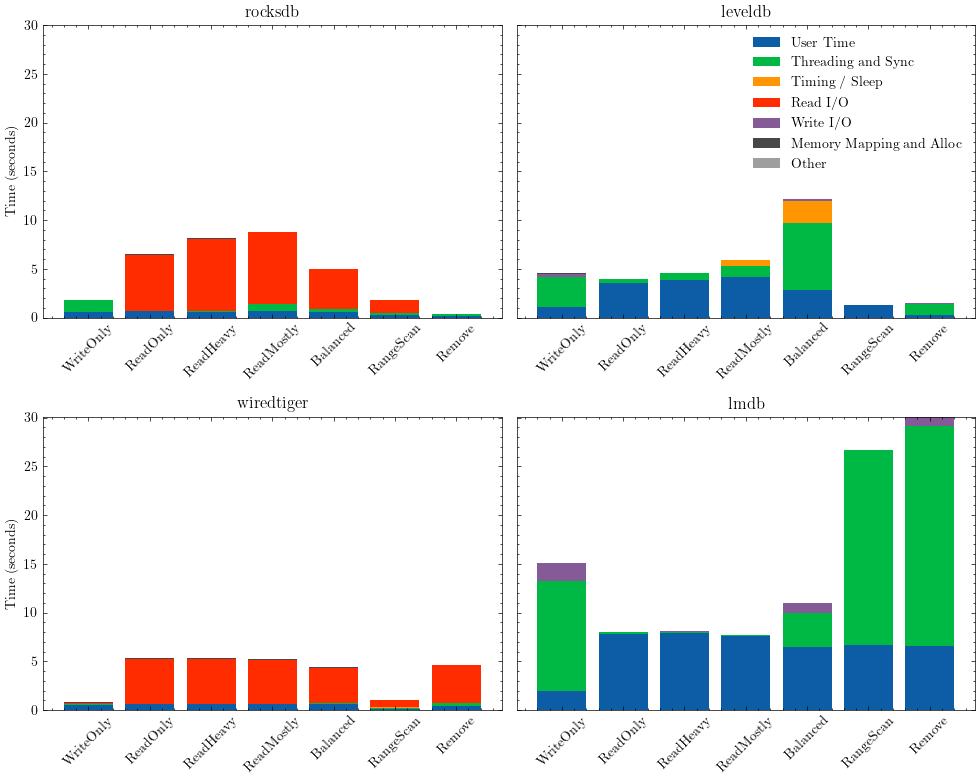

In [17]:
plot_per_db_per_wl(data)

In [18]:
data_single = [[kernel_user_time_of_workload_single_threaded(db_name, workload) for workload in workload_names] for db_name in db_names]

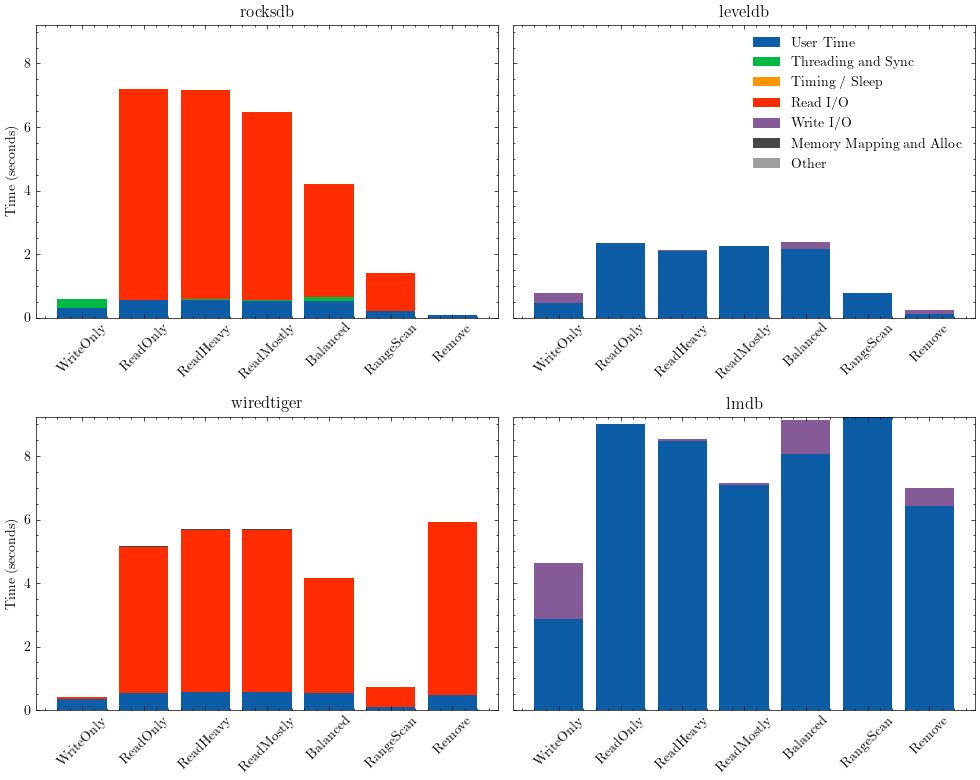

In [19]:
plot_per_db_per_wl(data_single)